In [1]:
import pandas as pd
import numpy as np
import json
import requests
import csv
import datetime

# Betting Data

This notebook will be used to condense multiple outlets of betting data into one csv file, clean the data, get locations, and perform some calculations regarding gambling outcomes.

## Combine Yearly Betting Data

Since the betting data is contained in multiple csv files, one for each year, I will combine them into one dataframe. My resource gave me data from 1978-2013, but I will only use data from 2002 (the year the NFL expanded to 32 teams) and onward.

In [177]:
def merge_files():
    yearly_data = []
    for year in np.arange(2002, 2014):
        filename = 'nfllines/nfl{}lines.csv'.format(year)
        data = pd.read_csv(filename)
        yearly_data.append(data)
        
    betting_data = pd.concat(yearly_data)
    return betting_data
        
betting_data = merge_files()

In [178]:
betting_data

,Date,Visitor,Visitor Score,Home Team,Home Score,Line,Total Line,Total Line
0,09/05/2002,San Francisco 49ers,16,New York Giants,13,-4.0,39.0,NaN
1,09/08/2002,Philadelphia Eagles,24,Tennessee Titans,27,2.0,37.0,NaN
2,09/08/2002,New York Jets,37,Buffalo Bills,31,-3.0,43.0,NaN
3,09/08/2002,Arizona Cardinals,23,Washington Redskins,31,6.0,44.5,NaN
4,09/08/2002,Baltimore Ravens,7,Carolina Panthers,10,0.0,33.0,NaN
...,...,...,...,...,...,...,...,...
251,12/29/2013,Tampa Bay Buccaneers,17,New Orleans Saints,42,10.5,46.5,NaN
252,12/29/2013,Denver Broncos,34,Oakland Raiders,14,-10.0,53.5,NaN
253,12/29/2013,San Francisco 49ers,23,Arizona Cardinals,20,3.0,41.0,NaN
254,12/29/2013,Kansas City Chiefs,24,San Diego Chargers,27,14.5,45.0,NaN


## Cleaning Data Part I

First I will reindex the dataframe, find the winners of each game, eliminate games that were played at a neutral site (to eliminate the games where home teams are assigned arbitrarily), and assign locations to each game. Neutral site games are those played outside the US (https://en.wikipedia.org/wiki/List_of_National_Football_League_games_played_outside_the_United_States) and the listed home games 2005 New Orleans Saints who were homeless after Hurricane Katrina. I will also eliminate games played between the New York Giants and the New York Jets since they share the same stadium and games between the two, although infrequent in the regular season, are not going to have a home field effect to nearly the extent that I would expect for a typical game.

### Reindexing

In [179]:
reindex = np.arange(len(betting_data))
betting_data.index = reindex
betting_data.columns = ['date', 'away_team', 'away_score', 'home_team', 'home_score', 'spread',
       'total_line', 'total_line_']
betting_data

,date,away_team,away_score,home_team,home_score,spread,total_line,total_line_
0,09/05/2002,San Francisco 49ers,16,New York Giants,13,-4.0,39.0,NaN
1,09/08/2002,Philadelphia Eagles,24,Tennessee Titans,27,2.0,37.0,NaN
2,09/08/2002,New York Jets,37,Buffalo Bills,31,-3.0,43.0,NaN
3,09/08/2002,Arizona Cardinals,23,Washington Redskins,31,6.0,44.5,NaN
4,09/08/2002,Baltimore Ravens,7,Carolina Panthers,10,0.0,33.0,NaN
...,...,...,...,...,...,...,...,...
3067,12/29/2013,Tampa Bay Buccaneers,17,New Orleans Saints,42,10.5,46.5,NaN
3068,12/29/2013,Denver Broncos,34,Oakland Raiders,14,-10.0,53.5,NaN
3069,12/29/2013,San Francisco 49ers,23,Arizona Cardinals,20,3.0,41.0,NaN
3070,12/29/2013,Kansas City Chiefs,24,San Diego Chargers,27,14.5,45.0,NaN


### Designating Winner

In [180]:
betting_data['away_score'] = betting_data['away_score'].astype(int)
betting_data['home_score'] = betting_data['home_score'].astype(int)

In [181]:
def winner(row):
    if row['away_score'] > row['home_score']:
        winning_team = 'Away'
    elif row['away_score'] < row['home_score']:
        winning_team = 'Home'
    elif row['away_score'] == row['home_score']:
        winning_team = 'Tie'
    return winning_team

betting_data['winner'] = betting_data.apply(winner, axis = 1)

betting_data

,date,away_team,away_score,home_team,home_score,spread,total_line,total_line_,winner
0,09/05/2002,San Francisco 49ers,16,New York Giants,13,-4.0,39.0,NaN,Away
1,09/08/2002,Philadelphia Eagles,24,Tennessee Titans,27,2.0,37.0,NaN,Home
2,09/08/2002,New York Jets,37,Buffalo Bills,31,-3.0,43.0,NaN,Away
3,09/08/2002,Arizona Cardinals,23,Washington Redskins,31,6.0,44.5,NaN,Home
4,09/08/2002,Baltimore Ravens,7,Carolina Panthers,10,0.0,33.0,NaN,Home
...,...,...,...,...,...,...,...,...,...
3067,12/29/2013,Tampa Bay Buccaneers,17,New Orleans Saints,42,10.5,46.5,NaN,Home
3068,12/29/2013,Denver Broncos,34,Oakland Raiders,14,-10.0,53.5,NaN,Away
3069,12/29/2013,San Francisco 49ers,23,Arizona Cardinals,20,3.0,41.0,NaN,Away
3070,12/29/2013,Kansas City Chiefs,24,San Diego Chargers,27,14.5,45.0,NaN,Home


### Date to appropriate format

In [182]:
betting_data['date'].describe()

count           3072
unique           502
top       01/02/2011
freq              16
Name: date, dtype: object

In [183]:
def get_year(series):
    date_str = series.split('/')
    year = int(date_str[2])
    return year



betting_data['year'] = betting_data['date'].apply(get_year)

    

In [184]:
def date_convert(series):
    date_str = series.split('/')
    month = int(date_str[0])
    day = int(date_str[1])
    year = int(date_str[2])
    return datetime.date(year, month, day)
betting_data['date'] = betting_data['date'].apply(date_convert)

In [185]:
betting_data

,date,away_team,away_score,home_team,home_score,spread,total_line,total_line_,winner,year
0,2002-09-05,San Francisco 49ers,16,New York Giants,13,-4.0,39.0,NaN,Away,2002
1,2002-09-08,Philadelphia Eagles,24,Tennessee Titans,27,2.0,37.0,NaN,Home,2002
2,2002-09-08,New York Jets,37,Buffalo Bills,31,-3.0,43.0,NaN,Away,2002
3,2002-09-08,Arizona Cardinals,23,Washington Redskins,31,6.0,44.5,NaN,Home,2002
4,2002-09-08,Baltimore Ravens,7,Carolina Panthers,10,0.0,33.0,NaN,Home,2002
...,...,...,...,...,...,...,...,...,...,...
3067,2013-12-29,Tampa Bay Buccaneers,17,New Orleans Saints,42,10.5,46.5,NaN,Home,2013
3068,2013-12-29,Denver Broncos,34,Oakland Raiders,14,-10.0,53.5,NaN,Away,2013
3069,2013-12-29,San Francisco 49ers,23,Arizona Cardinals,20,3.0,41.0,NaN,Away,2013
3070,2013-12-29,Kansas City Chiefs,24,San Diego Chargers,27,14.5,45.0,NaN,Home,2013


### Eliminate Neutral Site Games

#### International

In [186]:
international = pd.read_html('https://en.wikipedia.org/wiki/List_of_National_Football_League_games_played_outside_the_United_States')[1]
international.columns
international.columns = ['Season', 'Date', 'Series', 'Type', 'Winning/Tied Team',
                        'Score', 'Losing/Tied Team', 'Stadium', 'City', 'Country',  'Ref' ]

In [187]:
international.head()

,Season,Date,Series,Type,Winning/Tied Team,Score,Losing/Tied Team,Stadium,City,Country,Ref
0,1926,November 8,–,REG,New York Yankees (AFL 1926),28–0,Los Angeles Wildcats (AFL 1926),Maple Leaf Stadium,Toronto,Canada,[26]
1,1948,August 19,CFL,INT,Brooklyn Dodgers (AAFC),27–1,Montreal Alouettes (CFL),Delorimier Stadium,Montreal,Canada,[27][28][29]
2,1950,August 12,CFL,INT,New York Giants,27–6,Ottawa Rough Riders (CFL),Lansdowne Park,Ottawa,Canada,[30]
3,1951,August 11,CFL,INT,New York Giants,41–18,Ottawa Rough Riders (CFL),Lansdowne Park,Ottawa,Canada,[31]
4,1959,August 5,CFL,INT,Chicago Cardinals,55–26,Toronto Argonauts (CFL),Exhibition Stadium,Toronto,Canada,NaN


In [188]:
international = international[international.Score != 'Cancelled']
international = international[international.Type == 'REG']
international = international[international.Season >= 2002]
international = international[international.Season <= 2013]
international

,Season,Date,Series,Type,Winning/Tied Team,Score,Losing/Tied Team,Stadium,City,Country,Ref
61,2005,October 2,FA,REG,Arizona Cardinals,31–14,San Francisco 49ers,Estadio Azteca,Mexico City,Mexico,NaN
63,2007,October 28,IS,REG,New York Giants,13–10,Miami Dolphins,Wembley Stadium,London,United Kingdom,NaN
65,2008,October 26,IS,REG,New Orleans Saints,37–32,San Diego Chargers,Wembley Stadium,London,United Kingdom,NaN
66,2008,December 7,BTS,REG,Miami Dolphins,16–3,Buffalo Bills,Rogers Centre,Toronto,Canada,[51]
67,2009,October 25,IS,REG,New England Patriots,35–7,Tampa Bay Buccaneers,Wembley Stadium,London,United Kingdom,NaN
68,2009,December 3,BTS,REG,New York Jets,19–13,Buffalo Bills,Rogers Centre,Toronto,Canada,[52]
70,2010,October 31,IS,REG,San Francisco 49ers,24–16,Denver Broncos,Wembley Stadium,London,United Kingdom,NaN
71,2010,November 7,BTS,REG,Chicago Bears,22–19,Buffalo Bills,Rogers Centre,Toronto,Canada,[54]
72,2011,October 23,IS,REG,Chicago Bears,24–18,Tampa Bay Buccaneers,Wembley Stadium,London,United Kingdom,NaN
73,2011,October 30,BTS,REG,Buffalo Bills,23–0,Washington Redskins,Rogers Centre,Toronto,Canada,[55]


In [189]:
def date_format(row):
    year = int(row['Season'])
    date_str = row['Date'].split()
    month_str = date_str[0]
    if month_str == 'September':
        month_int = 9
    elif month_str == 'October':
        month_int = 10
    elif month_str == 'November':
        month_int = 11
    elif month_str == 'December':
        month_int = 12
    day = int(date_str[1])
    date = datetime.date(year, month_int, day)
    return date

international['Datetime'] = international.apply(date_format, axis = 1)

In [190]:
international = international[['Season', 'Datetime', 'Winning/Tied Team', 'Score', 'Losing/Tied Team']]
international

,Season,Datetime,Winning/Tied Team,Score,Losing/Tied Team
61,2005,2005-10-02,Arizona Cardinals,31–14,San Francisco 49ers
63,2007,2007-10-28,New York Giants,13–10,Miami Dolphins
65,2008,2008-10-26,New Orleans Saints,37–32,San Diego Chargers
66,2008,2008-12-07,Miami Dolphins,16–3,Buffalo Bills
67,2009,2009-10-25,New England Patriots,35–7,Tampa Bay Buccaneers
68,2009,2009-12-03,New York Jets,19–13,Buffalo Bills
70,2010,2010-10-31,San Francisco 49ers,24–16,Denver Broncos
71,2010,2010-11-07,Chicago Bears,22–19,Buffalo Bills
72,2011,2011-10-23,Chicago Bears,24–18,Tampa Bay Buccaneers
73,2011,2011-10-30,Buffalo Bills,23–0,Washington Redskins


In [191]:
def team_check(date, teamname):
    game = international[international['Datetime'] == date]
    if (sum(game['Winning/Tied Team'].str.contains(teamname)) + sum(game['Losing/Tied Team'].str.contains(teamname))) == 1:
        return 1
    else: 
        return 0

def is_inter(row):
    if row['date'] in international['Datetime'].values:
        is_international = team_check(row['date'], row['away_team'])
    else:
        is_international = 0
    return is_international

betting_data['is_inter'] = betting_data.apply(is_inter, axis = 1)
betting_data = betting_data[betting_data['is_inter'] == 0]
betting_data


    
        


,date,away_team,away_score,home_team,home_score,spread,total_line,total_line_,winner,year,is_inter
0,2002-09-05,San Francisco 49ers,16,New York Giants,13,-4.0,39.0,NaN,Away,2002,0
1,2002-09-08,Philadelphia Eagles,24,Tennessee Titans,27,2.0,37.0,NaN,Home,2002,0
2,2002-09-08,New York Jets,37,Buffalo Bills,31,-3.0,43.0,NaN,Away,2002,0
3,2002-09-08,Arizona Cardinals,23,Washington Redskins,31,6.0,44.5,NaN,Home,2002,0
4,2002-09-08,Baltimore Ravens,7,Carolina Panthers,10,0.0,33.0,NaN,Home,2002,0
...,...,...,...,...,...,...,...,...,...,...,...
3067,2013-12-29,Tampa Bay Buccaneers,17,New Orleans Saints,42,10.5,46.5,NaN,Home,2013,0
3068,2013-12-29,Denver Broncos,34,Oakland Raiders,14,-10.0,53.5,NaN,Away,2013,0
3069,2013-12-29,San Francisco 49ers,23,Arizona Cardinals,20,3.0,41.0,NaN,Away,2013,0
3070,2013-12-29,Kansas City Chiefs,24,San Diego Chargers,27,14.5,45.0,NaN,Home,2013,0


#### Get 2005 Saints Home games

In [192]:
def saints_05(row):
    if (row['date'].year == 2005) and (row['home_team'] == 'New Orleans Saints'):
        return 1
    else: 
        return 0


betting_data['saints_05'] = betting_data.apply(saints_05, axis = 1)
betting_data

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,away_team,away_score,home_team,home_score,spread,total_line,total_line_,winner,year,is_inter,saints_05
0,2002-09-05,San Francisco 49ers,16,New York Giants,13,-4.0,39.0,NaN,Away,2002,0,0
1,2002-09-08,Philadelphia Eagles,24,Tennessee Titans,27,2.0,37.0,NaN,Home,2002,0,0
2,2002-09-08,New York Jets,37,Buffalo Bills,31,-3.0,43.0,NaN,Away,2002,0,0
3,2002-09-08,Arizona Cardinals,23,Washington Redskins,31,6.0,44.5,NaN,Home,2002,0,0
4,2002-09-08,Baltimore Ravens,7,Carolina Panthers,10,0.0,33.0,NaN,Home,2002,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3067,2013-12-29,Tampa Bay Buccaneers,17,New Orleans Saints,42,10.5,46.5,NaN,Home,2013,0,0
3068,2013-12-29,Denver Broncos,34,Oakland Raiders,14,-10.0,53.5,NaN,Away,2013,0,0
3069,2013-12-29,San Francisco 49ers,23,Arizona Cardinals,20,3.0,41.0,NaN,Away,2013,0,0
3070,2013-12-29,Kansas City Chiefs,24,San Diego Chargers,27,14.5,45.0,NaN,Home,2013,0,0


#### Battle of New York

In [193]:
def ny_ny(row):
    if (row['away_team'] == 'New York Jets') and (row['home_team'] == 'New York Giants'):
        return 1
    elif (row['home_team'] == 'New York Jets') and (row['away_team'] == 'New York Giants'):
        return 1
    else:
        return 0
    
betting_data['ny_ny'] = betting_data.apply(ny_ny, axis = 1)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


#### Drop neutral site games

In [194]:
betting_data = betting_data[(betting_data['is_inter'] == 0) & (betting_data['saints_05'] == 0) & (betting_data['ny_ny'] == 0)]

In [195]:
betting_data = betting_data.drop(columns = ['is_inter', 'saints_05'])

In [196]:
betting_data

,date,away_team,away_score,home_team,home_score,spread,total_line,total_line_,winner,year,ny_ny
0,2002-09-05,San Francisco 49ers,16,New York Giants,13,-4.0,39.0,NaN,Away,2002,0
1,2002-09-08,Philadelphia Eagles,24,Tennessee Titans,27,2.0,37.0,NaN,Home,2002,0
2,2002-09-08,New York Jets,37,Buffalo Bills,31,-3.0,43.0,NaN,Away,2002,0
3,2002-09-08,Arizona Cardinals,23,Washington Redskins,31,6.0,44.5,NaN,Home,2002,0
4,2002-09-08,Baltimore Ravens,7,Carolina Panthers,10,0.0,33.0,NaN,Home,2002,0
...,...,...,...,...,...,...,...,...,...,...,...
3067,2013-12-29,Tampa Bay Buccaneers,17,New Orleans Saints,42,10.5,46.5,NaN,Home,2013,0
3068,2013-12-29,Denver Broncos,34,Oakland Raiders,14,-10.0,53.5,NaN,Away,2013,0
3069,2013-12-29,San Francisco 49ers,23,Arizona Cardinals,20,3.0,41.0,NaN,Away,2013,0
3070,2013-12-29,Kansas City Chiefs,24,San Diego Chargers,27,14.5,45.0,NaN,Home,2013,0


## Cleaning Data Part II

Here, I will reindex the data, cobine two columns that are incomplete and equivelent, and find the betting favorite of each game.

### Reindexing

In [197]:
reindex = np.arange(len(betting_data))
betting_data.index = reindex
betting_data

,date,away_team,away_score,home_team,home_score,spread,total_line,total_line_,winner,year,ny_ny
0,2002-09-05,San Francisco 49ers,16,New York Giants,13,-4.0,39.0,NaN,Away,2002,0
1,2002-09-08,Philadelphia Eagles,24,Tennessee Titans,27,2.0,37.0,NaN,Home,2002,0
2,2002-09-08,New York Jets,37,Buffalo Bills,31,-3.0,43.0,NaN,Away,2002,0
3,2002-09-08,Arizona Cardinals,23,Washington Redskins,31,6.0,44.5,NaN,Home,2002,0
4,2002-09-08,Baltimore Ravens,7,Carolina Panthers,10,0.0,33.0,NaN,Home,2002,0
...,...,...,...,...,...,...,...,...,...,...,...
3042,2013-12-29,Tampa Bay Buccaneers,17,New Orleans Saints,42,10.5,46.5,NaN,Home,2013,0
3043,2013-12-29,Denver Broncos,34,Oakland Raiders,14,-10.0,53.5,NaN,Away,2013,0
3044,2013-12-29,San Francisco 49ers,23,Arizona Cardinals,20,3.0,41.0,NaN,Away,2013,0
3045,2013-12-29,Kansas City Chiefs,24,San Diego Chargers,27,14.5,45.0,NaN,Home,2013,0


### Total Line

At least one of the CSVs had a title of 'Total Line ' with an extra space. This means that there are two columns that serve the same purpose, so they need to be combined. I am also changing the name of it to 'over_under' because this category is normally called the 'Over/Under' (or just 'The Over'). 

In [198]:
# If this statement is true, then each row has exactly
# one value for either total_line or total_line_
betting_data['total_line'].count() + betting_data['total_line_'].count() == len(betting_data)

True

In [199]:
betting_data['total_line'] = betting_data['total_line'].fillna(0)
betting_data['total_line_'] = betting_data['total_line_'].fillna(0)

In [200]:
betting_data['over_under'] = betting_data['total_line'] + betting_data['total_line_']
betting_data

,date,away_team,away_score,home_team,home_score,spread,total_line,total_line_,winner,year,ny_ny,over_under
0,2002-09-05,San Francisco 49ers,16,New York Giants,13,-4.0,39.0,0.0,Away,2002,0,39.0
1,2002-09-08,Philadelphia Eagles,24,Tennessee Titans,27,2.0,37.0,0.0,Home,2002,0,37.0
2,2002-09-08,New York Jets,37,Buffalo Bills,31,-3.0,43.0,0.0,Away,2002,0,43.0
3,2002-09-08,Arizona Cardinals,23,Washington Redskins,31,6.0,44.5,0.0,Home,2002,0,44.5
4,2002-09-08,Baltimore Ravens,7,Carolina Panthers,10,0.0,33.0,0.0,Home,2002,0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3042,2013-12-29,Tampa Bay Buccaneers,17,New Orleans Saints,42,10.5,46.5,0.0,Home,2013,0,46.5
3043,2013-12-29,Denver Broncos,34,Oakland Raiders,14,-10.0,53.5,0.0,Away,2013,0,53.5
3044,2013-12-29,San Francisco 49ers,23,Arizona Cardinals,20,3.0,41.0,0.0,Away,2013,0,41.0
3045,2013-12-29,Kansas City Chiefs,24,San Diego Chargers,27,14.5,45.0,0.0,Home,2013,0,45.0


In [201]:
betting_data = betting_data.drop(columns = ['total_line', 'total_line_'])

In [202]:
betting_data

,date,away_team,away_score,home_team,home_score,spread,winner,year,ny_ny,over_under
0,2002-09-05,San Francisco 49ers,16,New York Giants,13,-4.0,Away,2002,0,39.0
1,2002-09-08,Philadelphia Eagles,24,Tennessee Titans,27,2.0,Home,2002,0,37.0
2,2002-09-08,New York Jets,37,Buffalo Bills,31,-3.0,Away,2002,0,43.0
3,2002-09-08,Arizona Cardinals,23,Washington Redskins,31,6.0,Home,2002,0,44.5
4,2002-09-08,Baltimore Ravens,7,Carolina Panthers,10,0.0,Home,2002,0,33.0
...,...,...,...,...,...,...,...,...,...,...
3042,2013-12-29,Tampa Bay Buccaneers,17,New Orleans Saints,42,10.5,Home,2013,0,46.5
3043,2013-12-29,Denver Broncos,34,Oakland Raiders,14,-10.0,Away,2013,0,53.5
3044,2013-12-29,San Francisco 49ers,23,Arizona Cardinals,20,3.0,Away,2013,0,41.0
3045,2013-12-29,Kansas City Chiefs,24,San Diego Chargers,27,14.5,Home,2013,0,45.0


### Get the betting favorite

When the game has a spread that is in the negatives, the away team is favorited by that number of points and vice versa. Games with a spread of 0 are commonly known as a "pick'em" because there is no favorite.

In [203]:
def get_favorite(spread):
    if spread > 0:
        return 'Home'
    elif spread < 0:
        return 'Away'
    else:
        return "Pick'em"
    
betting_data['favorite'] = betting_data['spread'].apply(get_favorite)
betting_data

,date,away_team,away_score,home_team,home_score,spread,winner,year,ny_ny,over_under,favorite
0,2002-09-05,San Francisco 49ers,16,New York Giants,13,-4.0,Away,2002,0,39.0,Away
1,2002-09-08,Philadelphia Eagles,24,Tennessee Titans,27,2.0,Home,2002,0,37.0,Home
2,2002-09-08,New York Jets,37,Buffalo Bills,31,-3.0,Away,2002,0,43.0,Away
3,2002-09-08,Arizona Cardinals,23,Washington Redskins,31,6.0,Home,2002,0,44.5,Home
4,2002-09-08,Baltimore Ravens,7,Carolina Panthers,10,0.0,Home,2002,0,33.0,Pick'em
...,...,...,...,...,...,...,...,...,...,...,...
3042,2013-12-29,Tampa Bay Buccaneers,17,New Orleans Saints,42,10.5,Home,2013,0,46.5,Home
3043,2013-12-29,Denver Broncos,34,Oakland Raiders,14,-10.0,Away,2013,0,53.5,Away
3044,2013-12-29,San Francisco 49ers,23,Arizona Cardinals,20,3.0,Away,2013,0,41.0,Home
3045,2013-12-29,Kansas City Chiefs,24,San Diego Chargers,27,14.5,Home,2013,0,45.0,Home


## Location Information

Here I will pick out the city from each team name so I can get a location to use for the weather API.

Additionally, I will note the games that were played indoors. Some stadiums use retractable roofs, but I will count all of those games as indoors since it will only be open if the conditions are fair. This wikipedia page (https://en.wikipedia.org/wiki/Chronology_of_home_stadiums_for_current_National_Football_League_teams) has a good list of the history of stadium use.

#### A few stray games to eliminate

The bottom of the Wikipedia list mentions a few games that were played at different stadiums for emergency purposes. I need to eliminate those games from the dataframe.

In [204]:
betting_data = betting_data.drop(columns = 'ny_ny')

In [205]:
betting_data = betting_data[(betting_data['date'] != datetime.date(2003, 10, 27)) | (betting_data['home_team'] != 'San Diego Chargers')]
betting_data = betting_data[(betting_data['date'] != datetime.date(2010, 12, 13)) | (betting_data['home_team'] != 'Minnesota Vikings')]
betting_data = betting_data[(betting_data['date'] != datetime.date(2005, 9, 19)) | (betting_data['home_team'] != 'New York Giants')]
reindex = np.arange(len(betting_data))
betting_data.index = reindex
betting_data

,date,away_team,away_score,home_team,home_score,spread,winner,year,over_under,favorite
0,2002-09-05,San Francisco 49ers,16,New York Giants,13,-4.0,Away,2002,39.0,Away
1,2002-09-08,Philadelphia Eagles,24,Tennessee Titans,27,2.0,Home,2002,37.0,Home
2,2002-09-08,New York Jets,37,Buffalo Bills,31,-3.0,Away,2002,43.0,Away
3,2002-09-08,Arizona Cardinals,23,Washington Redskins,31,6.0,Home,2002,44.5,Home
4,2002-09-08,Baltimore Ravens,7,Carolina Panthers,10,0.0,Home,2002,33.0,Pick'em
...,...,...,...,...,...,...,...,...,...,...
3039,2013-12-29,Tampa Bay Buccaneers,17,New Orleans Saints,42,10.5,Home,2013,46.5,Home
3040,2013-12-29,Denver Broncos,34,Oakland Raiders,14,-10.0,Away,2013,53.5,Away
3041,2013-12-29,San Francisco 49ers,23,Arizona Cardinals,20,3.0,Away,2013,41.0,Home
3042,2013-12-29,Kansas City Chiefs,24,San Diego Chargers,27,14.5,Home,2013,45.0,Home


#### Find the City

#### Get the location

Dictionary of stadium locations key:value = team_name:(stadium_city, is_indoors). The values of is_indoors are based off their stadiums in 2002. There are a few exceptions of teams whose values change during that time, and I will update them later.

In [206]:
loc_dict = {
'Arizona Cardinals': ('Tempe, AZ', 'No'),
'Atlanta Falcons': ('Atlanta, GA', 'Yes'),
'Baltimore Ravens': ('Baltimore, MD', 'No'),
'Buffalo Bills': ('Buffalo, NY', 'No'),
'Carolina Panthers': ('Charlotte, NC', 'No'),
'Chicago Bears': ('Chicago, IL', 'No'),
'Cincinnati Bengals': ('Cincinnati, OH', 'No'),
'Cleveland Browns': ('Cleveland, OH', 'No'),
'Dallas Cowboys': ('Arlington, TX', 'No'),
'Denver Broncos': ('Denver, CO', 'No'),
'Detroit Lions': ('Detroit, MI', 'Yes'),
'Green Bay Packers': ('Green Bay, WI', 'No'),
'Houston Texans': ('Houston, TX',  'Yes'),
'Indianapolis Colts': ('Indianapolis, IN', 'Yes'),
'Jacksonville Jaguars': ('Jacksonville, FL', 'No'),
'Kansas City Chiefs': ('Kansas City, MO', 'No'),
'San Diego Chargers': ('San Diego, CA', 'No'),
'St Louis Rams': ('St Louis, MO', 'Yes'),
'St. Louis Rams': ('St Louis, MO', 'Yes'), ## Counting them twice to account for spelling
'Miami Dolphins': ('Miami, FL', 'No'),
'Minnesota Vikings': ('Minneapolis, MN', 'Yes'),
'New England Patriots': ('Foxborough, MA',  'No'),
'New Orleans Saints': ('New Orleans, LA', 'Yes'),
'New York Giants': ('East Rutherford, NJ', 'No'),
'New York Jets': ('East Rutherford, NJ', 'No'),
'Oakland Raiders': ('Oakland, CA', 'No'),
'Philadelphia Eagles': ('Philadelphia, PA', 'No'),
'Pittsburgh Steelers': ('Pittsburgh, PA', 'No'),
'San Francisco 49ers': ('San Francisco, CA', 'No'),
'Seattle Seahawks': ('Seattle, WA', 'No'),
'Tampa Bay Buccaneers': ('Tampa, FL', 'No'),
'Tennessee Titans': ('Nashville, TN',  'No'),
'Washington Redskins': ('Landover, MD', 'No')
}

In [207]:
betting_data['location'] = betting_data['home_team'].apply(lambda x: loc_dict[x][0])
betting_data

,date,away_team,away_score,home_team,home_score,spread,winner,year,over_under,favorite,location
0,2002-09-05,San Francisco 49ers,16,New York Giants,13,-4.0,Away,2002,39.0,Away,"East Rutherford, NJ"
1,2002-09-08,Philadelphia Eagles,24,Tennessee Titans,27,2.0,Home,2002,37.0,Home,"Nashville, TN"
2,2002-09-08,New York Jets,37,Buffalo Bills,31,-3.0,Away,2002,43.0,Away,"Buffalo, NY"
3,2002-09-08,Arizona Cardinals,23,Washington Redskins,31,6.0,Home,2002,44.5,Home,"Landover, MD"
4,2002-09-08,Baltimore Ravens,7,Carolina Panthers,10,0.0,Home,2002,33.0,Pick'em,"Charlotte, NC"
...,...,...,...,...,...,...,...,...,...,...,...
3039,2013-12-29,Tampa Bay Buccaneers,17,New Orleans Saints,42,10.5,Home,2013,46.5,Home,"New Orleans, LA"
3040,2013-12-29,Denver Broncos,34,Oakland Raiders,14,-10.0,Away,2013,53.5,Away,"Oakland, CA"
3041,2013-12-29,San Francisco 49ers,23,Arizona Cardinals,20,3.0,Away,2013,41.0,Home,"Tempe, AZ"
3042,2013-12-29,Kansas City Chiefs,24,San Diego Chargers,27,14.5,Home,2013,45.0,Home,"San Diego, CA"


Now that there is a date and location for each game, I should be able to get historical weather data for all of them. But first, I need to specify which games were played indoors. Although the historical stadiums Wikipedia page does not specify if stadiums were open, close, or rectactable roofed, I was able to dig through myself to see which ones were which.

Most teams played in a stadium that had the same type of roofing for the duration of this data. The exceptions are the Arizona Cardinals (outdoors until 2005, indoors from 2006), the Dallas Cowboys (outdoors until 2008, indoors from 2009), and the Minnesota Vikings (indoors except for 2014-2015 and one game in 2010).

In [208]:
betting_data['is_indoors'] = betting_data['home_team'].apply(lambda x: loc_dict[x][1])

betting_data2 = betting_data.copy()

def adjust_indoors(row):
    if (row['home_team'] == 'Arizona Cardinals') and (row['date'] > datetime.date(2006, 7, 1)):
        return 'Yes'
    elif (row['home_team'] == 'Dallas Cowboys') and (row['date'] > datetime.date(2009, 7, 1)):
        return 'Yes'
    elif (row['home_team'] == 'Minnesota Vikings') and (row['date'] > datetime.date(2014, 7, 1)) and (row['date'] < datetime.datetime(2016, 7, 1)):
        return 'No'
    elif (row['home_team'] == 'Minnesota Vikings') and (row['date'] == datetime.date(2010, 12, 20)):
        return 'No'
    else:
        return row['is_indoors']

betting_data2['is_indoors'] = betting_data2.apply(adjust_indoors, axis = 1)
print(len(betting_data2[betting_data2['is_indoors'] == 'Yes'])) ## These two should print different numbers
print(len(betting_data[betting_data['is_indoors'] == 'Yes'])) ## if the code worked properly

betting_data = betting_data2
betting_data

763
660


,date,away_team,away_score,home_team,home_score,spread,winner,year,over_under,favorite,location,is_indoors
0,2002-09-05,San Francisco 49ers,16,New York Giants,13,-4.0,Away,2002,39.0,Away,"East Rutherford, NJ",No
1,2002-09-08,Philadelphia Eagles,24,Tennessee Titans,27,2.0,Home,2002,37.0,Home,"Nashville, TN",No
2,2002-09-08,New York Jets,37,Buffalo Bills,31,-3.0,Away,2002,43.0,Away,"Buffalo, NY",No
3,2002-09-08,Arizona Cardinals,23,Washington Redskins,31,6.0,Home,2002,44.5,Home,"Landover, MD",No
4,2002-09-08,Baltimore Ravens,7,Carolina Panthers,10,0.0,Home,2002,33.0,Pick'em,"Charlotte, NC",No
...,...,...,...,...,...,...,...,...,...,...,...,...
3039,2013-12-29,Tampa Bay Buccaneers,17,New Orleans Saints,42,10.5,Home,2013,46.5,Home,"New Orleans, LA",Yes
3040,2013-12-29,Denver Broncos,34,Oakland Raiders,14,-10.0,Away,2013,53.5,Away,"Oakland, CA",No
3041,2013-12-29,San Francisco 49ers,23,Arizona Cardinals,20,3.0,Away,2013,41.0,Home,"Tempe, AZ",Yes
3042,2013-12-29,Kansas City Chiefs,24,San Diego Chargers,27,14.5,Home,2013,45.0,Home,"San Diego, CA",No


## Betting Results

This is where I will calculate betting results of games, such as if the over/under hit (i.e. the combined score > over/under line). The metric will be listed in headers.

### Over/Under

This is the part mentioned before. It should be noted that it is possible for there to be a tie (i.e. the combined score = the over/under) and those instances will be labled a 'push'.

In [209]:
def over_under_result(row):
    combined = row['home_score'] + row['away_score']
    line = row['over_under']
    if combined > line:
        return 'Over'
    elif combined < line:
        return 'Under'
    else:
        return 'Push'
    
betting_data['over_under_result'] = betting_data.apply(over_under_result, axis = 1)
betting_data['combined_score'] = betting_data['home_score'] + betting_data['away_score']
betting_data

,date,away_team,away_score,home_team,home_score,spread,winner,year,over_under,favorite,location,is_indoors,over_under_result,combined_score
0,2002-09-05,San Francisco 49ers,16,New York Giants,13,-4.0,Away,2002,39.0,Away,"East Rutherford, NJ",No,Under,29
1,2002-09-08,Philadelphia Eagles,24,Tennessee Titans,27,2.0,Home,2002,37.0,Home,"Nashville, TN",No,Over,51
2,2002-09-08,New York Jets,37,Buffalo Bills,31,-3.0,Away,2002,43.0,Away,"Buffalo, NY",No,Over,68
3,2002-09-08,Arizona Cardinals,23,Washington Redskins,31,6.0,Home,2002,44.5,Home,"Landover, MD",No,Over,54
4,2002-09-08,Baltimore Ravens,7,Carolina Panthers,10,0.0,Home,2002,33.0,Pick'em,"Charlotte, NC",No,Under,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3039,2013-12-29,Tampa Bay Buccaneers,17,New Orleans Saints,42,10.5,Home,2013,46.5,Home,"New Orleans, LA",Yes,Over,59
3040,2013-12-29,Denver Broncos,34,Oakland Raiders,14,-10.0,Away,2013,53.5,Away,"Oakland, CA",No,Under,48
3041,2013-12-29,San Francisco 49ers,23,Arizona Cardinals,20,3.0,Away,2013,41.0,Home,"Tempe, AZ",Yes,Over,43
3042,2013-12-29,Kansas City Chiefs,24,San Diego Chargers,27,14.5,Home,2013,45.0,Home,"San Diego, CA",No,Over,51


### Covering the spread

Earlier in this notebook, I calculated which team won the game. Here, I am calculating to see who 'covered the spread' which means the favorited team must win by more than the number of points by which they are favorited, or the away team wins, or loses by fewer points by which they are underdogs. Like above, a tie results in a 'push'.

In [210]:
def spread_cover(row):
    adj_away_score = row['away_score'] + row['spread'] ## The spread column adjusts points for the away team
    home_score = row['home_score']
    if adj_away_score > home_score:
        return 'Away'
    elif adj_away_score < home_score:
        return 'Home'
    else:
        return 'Push'
                     
betting_data['spread_cover'] = betting_data.apply(spread_cover, axis = 1)
betting_data

,date,away_team,away_score,home_team,home_score,spread,winner,year,over_under,favorite,location,is_indoors,over_under_result,combined_score,spread_cover
0,2002-09-05,San Francisco 49ers,16,New York Giants,13,-4.0,Away,2002,39.0,Away,"East Rutherford, NJ",No,Under,29,Home
1,2002-09-08,Philadelphia Eagles,24,Tennessee Titans,27,2.0,Home,2002,37.0,Home,"Nashville, TN",No,Over,51,Home
2,2002-09-08,New York Jets,37,Buffalo Bills,31,-3.0,Away,2002,43.0,Away,"Buffalo, NY",No,Over,68,Away
3,2002-09-08,Arizona Cardinals,23,Washington Redskins,31,6.0,Home,2002,44.5,Home,"Landover, MD",No,Over,54,Home
4,2002-09-08,Baltimore Ravens,7,Carolina Panthers,10,0.0,Home,2002,33.0,Pick'em,"Charlotte, NC",No,Under,17,Home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3039,2013-12-29,Tampa Bay Buccaneers,17,New Orleans Saints,42,10.5,Home,2013,46.5,Home,"New Orleans, LA",Yes,Over,59,Home
3040,2013-12-29,Denver Broncos,34,Oakland Raiders,14,-10.0,Away,2013,53.5,Away,"Oakland, CA",No,Under,48,Away
3041,2013-12-29,San Francisco 49ers,23,Arizona Cardinals,20,3.0,Away,2013,41.0,Home,"Tempe, AZ",Yes,Over,43,Away
3042,2013-12-29,Kansas City Chiefs,24,San Diego Chargers,27,14.5,Home,2013,45.0,Home,"San Diego, CA",No,Over,51,Away


### Score Differences

The differences in raw score, spread-adjusted score, and combined score (vs over/under).

In [211]:
betting_data['raw_margin'] = betting_data['away_score'] - betting_data['home_score'] ## Positive value = win for the away team, etc.
betting_data['over_under_margin'] = betting_data['combined_score'] - betting_data['over_under']
betting_data['spread_margin'] = betting_data['raw_margin'] + betting_data['spread']
betting_data

,date,away_team,away_score,home_team,home_score,spread,winner,year,over_under,favorite,location,is_indoors,over_under_result,combined_score,spread_cover,raw_margin,over_under_margin,spread_margin
0,2002-09-05,San Francisco 49ers,16,New York Giants,13,-4.0,Away,2002,39.0,Away,"East Rutherford, NJ",No,Under,29,Home,3,-10.0,-1.0
1,2002-09-08,Philadelphia Eagles,24,Tennessee Titans,27,2.0,Home,2002,37.0,Home,"Nashville, TN",No,Over,51,Home,-3,14.0,-1.0
2,2002-09-08,New York Jets,37,Buffalo Bills,31,-3.0,Away,2002,43.0,Away,"Buffalo, NY",No,Over,68,Away,6,25.0,3.0
3,2002-09-08,Arizona Cardinals,23,Washington Redskins,31,6.0,Home,2002,44.5,Home,"Landover, MD",No,Over,54,Home,-8,9.5,-2.0
4,2002-09-08,Baltimore Ravens,7,Carolina Panthers,10,0.0,Home,2002,33.0,Pick'em,"Charlotte, NC",No,Under,17,Home,-3,-16.0,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3039,2013-12-29,Tampa Bay Buccaneers,17,New Orleans Saints,42,10.5,Home,2013,46.5,Home,"New Orleans, LA",Yes,Over,59,Home,-25,12.5,-14.5
3040,2013-12-29,Denver Broncos,34,Oakland Raiders,14,-10.0,Away,2013,53.5,Away,"Oakland, CA",No,Under,48,Away,20,-5.5,10.0
3041,2013-12-29,San Francisco 49ers,23,Arizona Cardinals,20,3.0,Away,2013,41.0,Home,"Tempe, AZ",Yes,Over,43,Away,3,2.0,6.0
3042,2013-12-29,Kansas City Chiefs,24,San Diego Chargers,27,14.5,Home,2013,45.0,Home,"San Diego, CA",No,Over,51,Away,-3,6.0,11.5


## CSV Export

I want to have this data in a CSV a) so I can export this to other notebooks, b) to set a checkpoint for how far I have to reset in case I mess up the data, and c) for my own future reference.

In [216]:
betting_data.to_csv('data/betting_data.csv', date_format='%Y%m%d', index= False)

### Testing to see if the export worked properly

In [225]:
csv_data = pd.read_csv('data/betting_data.csv')

In [222]:
type(csv_data.loc[1, 'date'])

str

In [223]:
type(betting_data.loc[1, 'date'])

datetime.date

In [229]:
type(csv_data.loc[1, 'year'])

numpy.int64

In [230]:
type(betting_data.loc[1, 'year'])

numpy.int64

When I open up my csv in a new notebook, I will have to convert the date column to python datetime format.

In [224]:
csv_data

,date,away_team,away_score,home_team,home_score,spread,winner,year,over_under,favorite,location,is_indoors,over_under_result,combined_score,spread_cover,raw_margin,over_under_margin,spread_margin
0,2002-09-05,San Francisco 49ers,16,New York Giants,13,-4.0,Away,2002,39.0,Away,"East Rutherford, NJ",No,Under,29,Home,3,-10.0,-1.0
1,2002-09-08,Philadelphia Eagles,24,Tennessee Titans,27,2.0,Home,2002,37.0,Home,"Nashville, TN",No,Over,51,Home,-3,14.0,-1.0
2,2002-09-08,New York Jets,37,Buffalo Bills,31,-3.0,Away,2002,43.0,Away,"Buffalo, NY",No,Over,68,Away,6,25.0,3.0
3,2002-09-08,Arizona Cardinals,23,Washington Redskins,31,6.0,Home,2002,44.5,Home,"Landover, MD",No,Over,54,Home,-8,9.5,-2.0
4,2002-09-08,Baltimore Ravens,7,Carolina Panthers,10,0.0,Home,2002,33.0,Pick'em,"Charlotte, NC",No,Under,17,Home,-3,-16.0,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3039,2013-12-29,Tampa Bay Buccaneers,17,New Orleans Saints,42,10.5,Home,2013,46.5,Home,"New Orleans, LA",Yes,Over,59,Home,-25,12.5,-14.5
3040,2013-12-29,Denver Broncos,34,Oakland Raiders,14,-10.0,Away,2013,53.5,Away,"Oakland, CA",No,Under,48,Away,20,-5.5,10.0
3041,2013-12-29,San Francisco 49ers,23,Arizona Cardinals,20,3.0,Away,2013,41.0,Home,"Tempe, AZ",Yes,Over,43,Away,3,2.0,6.0
3042,2013-12-29,Kansas City Chiefs,24,San Diego Chargers,27,14.5,Home,2013,45.0,Home,"San Diego, CA",No,Over,51,Away,-3,6.0,11.5


### Convert Date Format

In [233]:
def csv_date_convert(series):
    date_str = series.split('-')
    year = int(date_str[0])
    month = int(date_str[1])
    day = int(date_str[2])
    return datetime.date(year, month, day)

csv_data['date'] = csv_data['date'].apply(csv_date_convert)


,date,away_team,away_score,home_team,home_score,spread,winner,year,over_under,favorite,location,is_indoors,over_under_result,combined_score,spread_cover,raw_margin,over_under_margin,spread_margin
0,2002-09-05,San Francisco 49ers,16,New York Giants,13,-4.0,Away,2002,39.0,Away,"East Rutherford, NJ",No,Under,29,Home,3,-10.0,-1.0
1,2002-09-08,Philadelphia Eagles,24,Tennessee Titans,27,2.0,Home,2002,37.0,Home,"Nashville, TN",No,Over,51,Home,-3,14.0,-1.0
2,2002-09-08,New York Jets,37,Buffalo Bills,31,-3.0,Away,2002,43.0,Away,"Buffalo, NY",No,Over,68,Away,6,25.0,3.0
3,2002-09-08,Arizona Cardinals,23,Washington Redskins,31,6.0,Home,2002,44.5,Home,"Landover, MD",No,Over,54,Home,-8,9.5,-2.0
4,2002-09-08,Baltimore Ravens,7,Carolina Panthers,10,0.0,Home,2002,33.0,Pick'em,"Charlotte, NC",No,Under,17,Home,-3,-16.0,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3039,2013-12-29,Tampa Bay Buccaneers,17,New Orleans Saints,42,10.5,Home,2013,46.5,Home,"New Orleans, LA",Yes,Over,59,Home,-25,12.5,-14.5
3040,2013-12-29,Denver Broncos,34,Oakland Raiders,14,-10.0,Away,2013,53.5,Away,"Oakland, CA",No,Under,48,Away,20,-5.5,10.0
3041,2013-12-29,San Francisco 49ers,23,Arizona Cardinals,20,3.0,Away,2013,41.0,Home,"Tempe, AZ",Yes,Over,43,Away,3,2.0,6.0
3042,2013-12-29,Kansas City Chiefs,24,San Diego Chargers,27,14.5,Home,2013,45.0,Home,"San Diego, CA",No,Over,51,Away,-3,6.0,11.5


In [235]:
type(csv_data.loc[1, 'date'])

datetime.date

In [237]:
betting_data = csv_data.copy() ## New betting data

## Historical Weather API

To get historical weather, I will be using the Visual Crossing Weather API. Since I do not have the times of kickoff, I will use 3:00 PM for each game.

In [319]:
api_key = 'IX436X651BKZIHR2M7VMPXTND'
example = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history?&aggregateHours=24&startDateTime=2019-01-30T00:00:00&endDateTime=2019-01-30T00:00:00&unitGroup=us&contentType=csv&dayStartTime=0:0:00&dayEndTime=0:0:00&location=Sterling,VA,US&key=YOURAPIKEY'
base_url = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history?'
add_on = '&aggregateHours=24&startDateTime=2019-01-30T00:00:00&endDateTime=2019-01-30T00:00:00&unitGroup=us&contentType=json&dayStartTime=0:0:00&dayEndTime=0:0:00&location=Sterling,VA,US&key={}'.format(api_key)

### Testing the API

In [320]:
r = requests.get(base_url+add_on)
data = r.json()
data

{'locations': {'Sterling,VA,US': {'stationContributions': None,
   'values': [{'wdir': 276.05,
     'temp': 17.3,
     'maxt': 31.5,
     'visibility': 9.3,
     'wspd': 24.9,
     'datetimeStr': '2019-01-30T00:00:00-05:00',
     'heatindex': None,
     'cloudcover': 19.8,
     'mint': 8.9,
     'datetime': 1548806400000,
     'precip': 0.0,
     'weathertype': 'Blowing Or Drifting Snow, Heavy Snow, Light Snow, Light Rain, Smoke Or Haze',
     'snowdepth': 1.2,
     'sealevelpressure': 1018.2,
     'dew': 6.3,
     'humidity': 63.31,
     'wgust': 40.3,
     'precipcover': 4.17,
     'conditions': 'Clear',
     'windchill': -4.5,
     'info': None}],
   'id': 'Sterling,VA,US',
   'address': 'Sterling,VA,US',
   'name': None,
   'index': 0,
   'latitude': 39.03335,
   'longitude': -77.40711,
   'distance': 0.0,
   'time': 0.0,
   'currentConditions': None,
   'alerts': None}},
 'columns': {'wdir': {'id': 'wdir',
   'name': 'Wind Direction',
   'type': 2,
   'unit': None},
  'latitude': 

In [253]:
temp = data['locations']['Sterling,VA,US']['values'][0]['temp']
temp

65.5

In [255]:
summary = data['locations']['Sterling,VA,US']['values'][0]
summary

{'wdir': 193.35,
 'temp': 65.5,
 'maxt': 74.8,
 'visibility': 7.7,
 'wspd': 11.2,
 'datetimeStr': '2019-06-13T00:00:00-04:00',
 'heatindex': None,
 'cloudcover': 91.0,
 'mint': 60.9,
 'datetime': 1560384000000,
 'precip': 0.7,
 'weathertype': 'Mist, Rain, Thunderstorm, Heavy Rain, Light Rain',
 'snowdepth': None,
 'sealevelpressure': 1009.7,
 'dew': 60.0,
 'humidity': 83.85,
 'wgust': 35.6,
 'precipcover': 41.67,
 'conditions': 'Rain, Overcast',
 'windchill': None,
 'info': None}

Data I want: temp (temperature), wspd (wind speed), conditions (Conditions, search for 'Rain' and 'Snow')

### Testing with data in set

In [256]:
betting_data_mini = betting_data.iloc[0:4, :]

In [257]:
betting_data_mini

,date,away_team,away_score,home_team,home_score,spread,winner,year,over_under,favorite,location,is_indoors,over_under_result,combined_score,spread_cover,raw_margin,over_under_margin,spread_margin
0,2002-09-05,San Francisco 49ers,16,New York Giants,13,-4.0,Away,2002,39.0,Away,"East Rutherford, NJ",No,Under,29,Home,3,-10.0,-1.0
1,2002-09-08,Philadelphia Eagles,24,Tennessee Titans,27,2.0,Home,2002,37.0,Home,"Nashville, TN",No,Over,51,Home,-3,14.0,-1.0
2,2002-09-08,New York Jets,37,Buffalo Bills,31,-3.0,Away,2002,43.0,Away,"Buffalo, NY",No,Over,68,Away,6,25.0,3.0
3,2002-09-08,Arizona Cardinals,23,Washington Redskins,31,6.0,Home,2002,44.5,Home,"Landover, MD",No,Over,54,Home,-8,9.5,-2.0


In [321]:
def get_weather_data(row):
    try:
        if row['is_indoors'] == 'Yes':
            return (None, None, None, None)
        else:
            date = row['date']
            year = date.year
            month = date.month
            day = date.day
            location = row['location']
            base_url = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history?'
            add_on = '&aggregateHours=24&startDateTime={}-{}-{}T15:00:00&endDateTime={}-{}-{}T15:00:00&unitGroup=us&contentType=json&dayStartTime=15:0:00&dayEndTime=15:0:00&location={},US&key={}'.format(
                year, month, day, year, month, day, location, api_key)
            r = requests.get(base_url+add_on)
            data = r.json()
            loc_str = '{},US'.format(location)
            temperature = data['locations'][loc_str]['values'][0]['temp']
            wind_speed = data['locations'][loc_str]['values'][0]['wspd']
            raining = ('Rain' in data['locations'][loc_str]['values'][0]['weathertype']) or ('Light Rain' in data['locations'][loc_str]['values'][0]['weathertype']) or ('Heavy Rain' in data['locations'][loc_str]['values'][0]['weathertype'])
            snowing = ('Snow' in data['locations'][loc_str]['values'][0]['weathertype']) or ('Light Snow' in data['locations'][loc_str]['values'][0]['weathertype']) or ('Heavy Snow' in data['locations'][loc_str]['values'][0]['weathertype'])
            return temperature, wind_speed, raining, snowing
#             return temperature, wind_speed
    except:
        
        return ('Error', 'Error', 'Error', 'Error')



In [322]:
weather_data_mini = betting_data_mini.apply(get_weather_data, axis = 1)
weather_data_mini

0      (80.7, 12.8, False, False)
1    (Error, Error, Error, Error)
2       (88.4, 6.7, False, False)
3       (80.7, 3.4, False, False)
dtype: object

In [323]:
weather_data_full = betting_data.apply(get_weather_data, axis = 1)

In [324]:
weather_data_full

0         (80.7, 12.8, False, False)
1       (Error, Error, Error, Error)
2          (88.4, 6.7, False, False)
3          (80.7, 3.4, False, False)
4          (82.1, 6.9, False, False)
                    ...             
3039        (None, None, None, None)
3040       (63.3, 6.5, False, False)
3041        (None, None, None, None)
3042       (70.7, 8.0, False, False)
3043       (45.4, 0.0, False, False)
Length: 3044, dtype: object

In [325]:
betting_data['temp'] = weather_data_full.str[0]
betting_data['wind_speed'] = weather_data_full.str[1]
betting_data['rain'] = weather_data_full.str[2]
betting_data['snow'] = weather_data_full.str[3]

In [326]:
betting_data

,date,away_team,away_score,home_team,home_score,spread,winner,year,over_under,favorite,...,over_under_result,combined_score,spread_cover,raw_margin,over_under_margin,spread_margin,temp,wind_speed,rain,snow
0,2002-09-05,San Francisco 49ers,16,New York Giants,13,-4.0,Away,2002,39.0,Away,...,Under,29,Home,3,-10.0,-1.0,80.7,12.8,False,False
1,2002-09-08,Philadelphia Eagles,24,Tennessee Titans,27,2.0,Home,2002,37.0,Home,...,Over,51,Home,-3,14.0,-1.0,Error,Error,Error,Error
2,2002-09-08,New York Jets,37,Buffalo Bills,31,-3.0,Away,2002,43.0,Away,...,Over,68,Away,6,25.0,3.0,88.4,6.7,False,False
3,2002-09-08,Arizona Cardinals,23,Washington Redskins,31,6.0,Home,2002,44.5,Home,...,Over,54,Home,-8,9.5,-2.0,80.7,3.4,False,False
4,2002-09-08,Baltimore Ravens,7,Carolina Panthers,10,0.0,Home,2002,33.0,Pick'em,...,Under,17,Home,-3,-16.0,-3.0,82.1,6.9,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3039,2013-12-29,Tampa Bay Buccaneers,17,New Orleans Saints,42,10.5,Home,2013,46.5,Home,...,Over,59,Home,-25,12.5,-14.5,None,None,None,None
3040,2013-12-29,Denver Broncos,34,Oakland Raiders,14,-10.0,Away,2013,53.5,Away,...,Under,48,Away,20,-5.5,10.0,63.3,6.5,False,False
3041,2013-12-29,San Francisco 49ers,23,Arizona Cardinals,20,3.0,Away,2013,41.0,Home,...,Over,43,Away,3,2.0,6.0,None,None,None,None
3042,2013-12-29,Kansas City Chiefs,24,San Diego Chargers,27,14.5,Home,2013,45.0,Home,...,Over,51,Away,-3,6.0,11.5,70.7,8,False,False


In [334]:
betting_data[(betting_data['wind_speed'] != 'Error') & (betting_data['wind_speed'] != None)]['wind_speed'].astype(float).describe()

count    2248.000000
mean        9.347331
std         5.093811
min         0.000000
25%         5.800000
50%         8.800000
75%        12.200000
max        41.400000
Name: wind_speed, dtype: float64

### Cleaning and splitting data

I was unable to get the weather data for 16 games, so I will eliminate those from the dataframe. From there, I want to split the dataframe to contain games that are only played indoors and another one with just outdoor games. I see the indoor games as 'weather neutral', and will be used as a reference. From there, I will reindex.

In [335]:
no_errors = betting_data[(betting_data['wind_speed'] != 'Error')]

In [337]:
indoors = no_errors[no_errors['is_indoors'] == 'Yes']
outdoors = no_errors[no_errors['is_indoors'] == 'No']

In [338]:
reindex = np.arange(len(indoors))
indoors.index = reindex
indoors

,date,away_team,away_score,home_team,home_score,spread,winner,year,over_under,favorite,...,over_under_result,combined_score,spread_cover,raw_margin,over_under_margin,spread_margin,temp,wind_speed,rain,snow
0,2002-09-08,Dallas Cowboys,10,Houston Texans,19,-8.5,Home,2002,33.5,Away,...,Under,29,Home,-9,-4.5,-17.5,None,None,None,None
1,2002-09-15,Miami Dolphins,21,Indianapolis Colts,13,0.0,Away,2002,47.0,Pick'em,...,Under,34,Away,8,-13.0,8.0,None,None,None,None
2,2002-09-15,Green Bay Packers,20,New Orleans Saints,35,-2.5,Home,2002,45.5,Away,...,Over,55,Home,-15,9.5,-17.5,None,None,None,None
3,2002-09-15,Chicago Bears,14,Atlanta Falcons,13,2.5,Away,2002,45.0,Home,...,Under,27,Away,1,-18.0,3.5,None,None,None,None
4,2002-09-15,New York Giants,26,St Louis Rams,21,12.0,Away,2002,46.0,Home,...,Over,47,Away,5,1.0,17.0,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,2013-12-29,Jacksonville Jaguars,10,Indianapolis Colts,30,11.5,Home,2013,45.0,Home,...,Under,40,Home,-20,-5.0,-8.5,None,None,None,None
759,2013-12-29,Philadelphia Eagles,24,Dallas Cowboys,22,-7.0,Away,2013,52.5,Away,...,Under,46,Home,2,-6.5,-5.0,None,None,None,None
760,2013-12-29,Detroit Lions,13,Minnesota Vikings,14,-2.5,Home,2013,49.5,Away,...,Under,27,Home,-1,-22.5,-3.5,None,None,None,None
761,2013-12-29,Tampa Bay Buccaneers,17,New Orleans Saints,42,10.5,Home,2013,46.5,Home,...,Over,59,Home,-25,12.5,-14.5,None,None,None,None


In [339]:
reindex = np.arange(len(outdoors))
outdoors.index = reindex
outdoors

,date,away_team,away_score,home_team,home_score,spread,winner,year,over_under,favorite,...,over_under_result,combined_score,spread_cover,raw_margin,over_under_margin,spread_margin,temp,wind_speed,rain,snow
0,2002-09-05,San Francisco 49ers,16,New York Giants,13,-4.0,Away,2002,39.0,Away,...,Under,29,Home,3,-10.0,-1.0,80.7,12.8,False,False
1,2002-09-08,New York Jets,37,Buffalo Bills,31,-3.0,Away,2002,43.0,Away,...,Over,68,Away,6,25.0,3.0,88.4,6.7,False,False
2,2002-09-08,Arizona Cardinals,23,Washington Redskins,31,6.0,Home,2002,44.5,Home,...,Over,54,Home,-8,9.5,-2.0,80.7,3.4,False,False
3,2002-09-08,Baltimore Ravens,7,Carolina Panthers,10,0.0,Home,2002,33.0,Pick'em,...,Under,17,Home,-3,-16.0,-3.0,82.1,6.9,False,False
4,2002-09-08,Minnesota Vikings,23,Chicago Bears,27,4.5,Home,2002,41.0,Home,...,Over,50,Away,-4,9.0,0.5,89.9,3.4,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260,2013-12-29,New York Jets,20,Miami Dolphins,7,7.0,Away,2013,41.0,Home,...,Under,27,Away,13,-14.0,20.0,79.1,12.1,False,False
2261,2013-12-29,Buffalo Bills,20,New England Patriots,34,7.0,Home,2013,46.0,Home,...,Over,54,Home,-14,8.0,-7.0,39.5,3.9,True,False
2262,2013-12-29,Denver Broncos,34,Oakland Raiders,14,-10.0,Away,2013,53.5,Away,...,Under,48,Away,20,-5.5,10.0,63.3,6.5,False,False
2263,2013-12-29,Kansas City Chiefs,24,San Diego Chargers,27,14.5,Home,2013,45.0,Home,...,Over,51,Away,-3,6.0,11.5,70.7,8,False,False


### Backing up data in CSV

So I don't have to run the API again if I lose the kernel. I will have to do the date format modification that I did for the first round ofg CSV backups. There will be serperate files for indoor and outdoor games.

In [341]:
outdoors.to_csv('data/outdoor_data.csv', date_format='%Y%m%d', index= False)

In [342]:
indoors.to_csv('data/indoor_data.csv', date_format='%Y%m%d', index= False)

In [343]:
csv_data_out = pd.read_csv('data/outdoor_data.csv')
csv_data_in = pd.read_csv('data/indoor_data.csv')

In [344]:
csv_data_out['date'] = csv_data_out['date'].apply(csv_date_convert)
outdoors = csv_data_out.copy()

csv_data_in['date'] = csv_data_in['date'].apply(csv_date_convert)
indoors = csv_data_in.copy()

In [345]:
indoors

,date,away_team,away_score,home_team,home_score,spread,winner,year,over_under,favorite,...,over_under_result,combined_score,spread_cover,raw_margin,over_under_margin,spread_margin,temp,wind_speed,rain,snow
0,2002-09-08,Dallas Cowboys,10,Houston Texans,19,-8.5,Home,2002,33.5,Away,...,Under,29,Home,-9,-4.5,-17.5,NaN,NaN,NaN,NaN
1,2002-09-15,Miami Dolphins,21,Indianapolis Colts,13,0.0,Away,2002,47.0,Pick'em,...,Under,34,Away,8,-13.0,8.0,NaN,NaN,NaN,NaN
2,2002-09-15,Green Bay Packers,20,New Orleans Saints,35,-2.5,Home,2002,45.5,Away,...,Over,55,Home,-15,9.5,-17.5,NaN,NaN,NaN,NaN
3,2002-09-15,Chicago Bears,14,Atlanta Falcons,13,2.5,Away,2002,45.0,Home,...,Under,27,Away,1,-18.0,3.5,NaN,NaN,NaN,NaN
4,2002-09-15,New York Giants,26,St Louis Rams,21,12.0,Away,2002,46.0,Home,...,Over,47,Away,5,1.0,17.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,2013-12-29,Jacksonville Jaguars,10,Indianapolis Colts,30,11.5,Home,2013,45.0,Home,...,Under,40,Home,-20,-5.0,-8.5,NaN,NaN,NaN,NaN
759,2013-12-29,Philadelphia Eagles,24,Dallas Cowboys,22,-7.0,Away,2013,52.5,Away,...,Under,46,Home,2,-6.5,-5.0,NaN,NaN,NaN,NaN
760,2013-12-29,Detroit Lions,13,Minnesota Vikings,14,-2.5,Home,2013,49.5,Away,...,Under,27,Home,-1,-22.5,-3.5,NaN,NaN,NaN,NaN
761,2013-12-29,Tampa Bay Buccaneers,17,New Orleans Saints,42,10.5,Home,2013,46.5,Home,...,Over,59,Home,-25,12.5,-14.5,NaN,NaN,NaN,NaN


In [346]:
outdoors

,date,away_team,away_score,home_team,home_score,spread,winner,year,over_under,favorite,...,over_under_result,combined_score,spread_cover,raw_margin,over_under_margin,spread_margin,temp,wind_speed,rain,snow
0,2002-09-05,San Francisco 49ers,16,New York Giants,13,-4.0,Away,2002,39.0,Away,...,Under,29,Home,3,-10.0,-1.0,80.7,12.8,False,False
1,2002-09-08,New York Jets,37,Buffalo Bills,31,-3.0,Away,2002,43.0,Away,...,Over,68,Away,6,25.0,3.0,88.4,6.7,False,False
2,2002-09-08,Arizona Cardinals,23,Washington Redskins,31,6.0,Home,2002,44.5,Home,...,Over,54,Home,-8,9.5,-2.0,80.7,3.4,False,False
3,2002-09-08,Baltimore Ravens,7,Carolina Panthers,10,0.0,Home,2002,33.0,Pick'em,...,Under,17,Home,-3,-16.0,-3.0,82.1,6.9,False,False
4,2002-09-08,Minnesota Vikings,23,Chicago Bears,27,4.5,Home,2002,41.0,Home,...,Over,50,Away,-4,9.0,0.5,89.9,3.4,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260,2013-12-29,New York Jets,20,Miami Dolphins,7,7.0,Away,2013,41.0,Home,...,Under,27,Away,13,-14.0,20.0,79.1,12.1,False,False
2261,2013-12-29,Buffalo Bills,20,New England Patriots,34,7.0,Home,2013,46.0,Home,...,Over,54,Home,-14,8.0,-7.0,39.5,3.9,True,False
2262,2013-12-29,Denver Broncos,34,Oakland Raiders,14,-10.0,Away,2013,53.5,Away,...,Under,48,Away,20,-5.5,10.0,63.3,6.5,False,False
2263,2013-12-29,Kansas City Chiefs,24,San Diego Chargers,27,14.5,Home,2013,45.0,Home,...,Over,51,Away,-3,6.0,11.5,70.7,8.0,False,False


In [393]:
combined = pd.concat([indoors, outdoors])

In [394]:
def get_weather_type(row):
    if row['is_indoors'] == "Yes":
        return 'indoors'
    elif (row['rain'] == True) or (row['snow'] == True):
        return 'rain/snow'
    else:
        return 'no rain/snow'

combined['weather_type'] = combined.apply(get_weather_type, axis = 1)

## 

For each game, I have four metrics of weather (temperature, wind speed, raining, and snowing) and three results (winner, spread, over/under) with their corresponding  margins (point differential, spread differential, and combined score) to measure the impact. Additionally, I can measure I can sort results by home/away and favorite/underdog.

For this project, I will focus on the three that I think are the most interesting. I want to include each metric of weather and each result. 

- Raining or Snowing vs Over/Under
- Wind speed vs Winner
- Temperature vs Spread

In [375]:
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from scipy import stats

In [347]:
outdoors.columns

Index(['date', 'away_team', 'away_score', 'home_team', 'home_score', 'spread',
       'winner', 'year', 'over_under', 'favorite', 'location', 'is_indoors',
       'over_under_result', 'combined_score', 'spread_cover', 'raw_margin',
       'over_under_margin', 'spread_margin', 'temp', 'wind_speed', 'rain',
       'snow'],
      dtype='object')

### Raining or Snowing vs Over/Under


There are three populations: outdoors games where it is raining or snowing, outdoor games where it is not raining or snowing, and indoor games. I will use the over_under_margin column to see how far off each game's combined score is from its listed over/under. I will first test statistical significance of population mean difference with a t-test for all three combinations.

Null: The two game conditions have the same population mean over/under margin

Alternative: The two game conditions have a different population mean over/under margin

In [349]:
rain_snow = outdoors[(outdoors['rain'] == True) | (outdoors['snow'] == True)]
no_rain_snow = outdoors[(outdoors['rain'] == False) & (outdoors['snow'] == False)]

#### Basic statistics of each population

In [352]:
## Rain or snow present
rain_snow['over_under_margin'].describe() 

count    195.000000
mean       0.448718
std       15.350121
min      -35.500000
25%      -10.750000
50%        0.000000
75%       10.250000
max       44.000000
Name: over_under_margin, dtype: float64

In [353]:
## No rain or snow present
no_rain_snow['over_under_margin'].describe() 

count    2070.000000
mean        0.941063
std        13.457904
min       -35.000000
25%        -8.000000
50%         0.000000
75%         9.500000
max        68.500000
Name: over_under_margin, dtype: float64

In [354]:
## Indoor games
indoors['over_under_margin'].describe() 

count    763.000000
mean       1.335518
std       13.026780
min      -36.000000
25%       -7.250000
50%        1.000000
75%        9.500000
max       46.500000
Name: over_under_margin, dtype: float64

#### Outdoors without rain/snow vs Indoors 

Null: The two game conditions have the same population mean over/under margin

Alternative: Outdoor games (no rain/snow) have a combined score that is less than the over/under margin compared to indoor games.

In [357]:
stats.ttest_ind(no_rain_snow['over_under_margin'], indoors['over_under_margin'], equal_var=False)

Ttest_indResult(statistic=-0.7085729400755736, pvalue=0.47870752221861834)

p = 0.4787, we cannot reject the null hypothesis

#### Outdoors with rain/snow vs Indoors 

Null: The two game conditions have the same population mean over/under margin

Alternative: Outdoor games (with rain/snow) have a combined score that is less than the over/under margin compared to indoor games.

In [363]:
## Gambling outcome
stats.ttest_ind(rain_snow['over_under_margin'], indoors['over_under_margin'], equal_var=False)

Ttest_indResult(statistic=-0.7413855344793873, pvalue=0.4591048672436525)

p = 0.4591, we cannot reject the null hypothesis

#### Outdoors with rain/snow vs Outdoors without rain/snow 

Null: The two game conditions have the same population mean over/under margin

Alternative: Outdoor games (with rain/snow) have a combined score that is less than the over/under margin compared to outdoor games without rain/snow.

In [361]:
stats.ttest_ind(rain_snow['over_under_margin'], no_rain_snow['over_under_margin'], equal_var=False)

Ttest_indResult(statistic=-0.4325084262464515, pvalue=0.6657898877206636)

p = 0.6658, we cannot reject the null hypothesis.

#### Combined scores

The previous t-tests were only for the gambling outcomes, which may be normalized for weather forecasts. I will informally redo the previous tests but for combined score.

In [367]:
## Rain/snow vs indoors
stats.ttest_ind(rain_snow['combined_score'], indoors['combined_score'], equal_var=False)

Ttest_indResult(statistic=-3.8970544475529296, pvalue=0.00012255435052591787)

In [368]:
## No Rain/snow vs indoors
stats.ttest_ind(no_rain_snow['combined_score'], indoors['combined_score'], equal_var=False)

Ttest_indResult(statistic=-5.77085035107493, pvalue=9.681786295836969e-09)

In [397]:
## No Rain/snow vs no rain/snow
stats.ttest_ind(no_rain_snow['combined_score'], rain_snow['combined_score'], equal_var=False)

Ttest_indResult(statistic=1.2155234882663115, pvalue=0.22544107192076115)

I can conclude that games played outdoors have fewer points scored than those played indoors. However, I could not find siginificance between the types of outdoor games. This means that sportsbooks adjust the over/unders for games based on forecasts

#### Visualizations

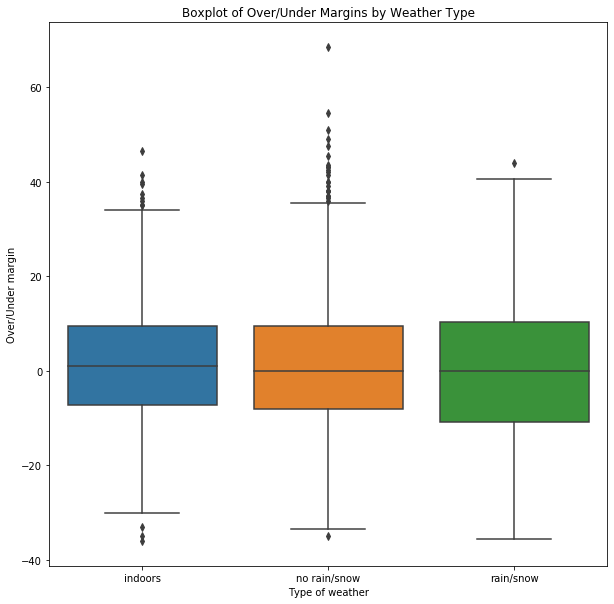

In [404]:
fig, ax = plt.subplots(figsize=(10,10));
fig = sns.boxplot(x="weather_type", y="over_under_margin", ax = ax, data=combined);
fig.set(xlabel = 'Type of weather', ylabel = 'Over/Under margin', title = 'Boxplot of Over/Under Margins by Weather Type');

### Wind Speed vs. Winner

There are two different ways to measure a winner, if it was the home or away team, or if it was the betting favorite or underdog. Since this project is about gambling, I will see if the winner was the favorite or the underdog mostly with regards to raw margin. I will look at I will look at the indoor vs outdoor games (both types of outdoors lumped together). I first need to do some data processing because the raw margin category is with respect to the home/away side winning, rather than the favorite or underdog. Negative values represent the underdog winning, and positive values represent the favorite winning. I will also eliminate games that have a 'pick'em' favorite.

#### Data manipulation

In [460]:
def winner_betting(row):
    if row['winner'] == row['favorite']:
        return abs(row['raw_margin']) ## Favorite wins, metric must be positive
    elif row['favorite'] == 'Home':
        return - row['raw_margin'] ## Away underdog wins, metric turns negative
    else:
        return row['raw_margin'] ## Home underdog wins, metric stays negative

## Apply to all dataframes
indoors['raw_margin_betting'] = indoors.apply(winner_betting, axis = 1)
outdoors['raw_margin_betting'] = outdoors.apply(winner_betting, axis = 1)

## Because there are some NaNs in the wind_speed column, I will drop those from the analysis
outdoors_wind = outdoors.dropna(subset = ['wind_speed'])

In [450]:
## Dropping games which have a pick'em favorite
indoors_nopickem = indoors_nopickem[indoors_nopickem['favorite'] != "Pick'em"]
outdoors_nopickem = outdoors_nopickem[outdoors_nopickem['favorite'] != "Pick'em"]

outdoors_wind = outdoors_nopickem.dropna(subset = ['wind_speed'])

#### Basic statistics of each population

In [451]:
indoors_nopickem['raw_margin_betting'].describe()

count    757.000000
mean       5.501982
std       13.280015
min      -35.000000
25%       -3.000000
50%        5.000000
75%       14.000000
max       55.000000
Name: raw_margin_betting, dtype: float64

In [452]:
outdoors_wind['raw_margin_betting'].describe()

count    2227.000000
mean        5.868433
std        14.293962
min       -45.000000
25%        -3.000000
50%         5.000000
75%        14.000000
max        59.000000
Name: raw_margin_betting, dtype: float64

In [453]:
outdoors_wind['wind_speed'].describe()

count    2227.000000
mean        9.349529
std         5.101935
min         0.000000
25%         5.800000
50%         8.800000
75%        12.200000
max        41.400000
Name: wind_speed, dtype: float64

#### t-test for population mean difference

Null: The two game conditions have the same population mean raw margin

Alternative: Betting favorites win by more in outdoor games compared to indoor games.

In [454]:
stats.ttest_ind(indoors_nopickem['raw_margin_betting'], outdoors_wind['raw_margin_betting'], equal_var=False)

Ttest_indResult(statistic=-0.6430790294748687, pvalue=0.5202784939223369)

Since p = 0.5203, there is no statistical significance that would allow me to reject the null hypothesis. This gives me a feeling that wind speed is probably not going to make an impact on this.

#### Regression

In [455]:
stats.linregress(x= outdoors_wind['wind_speed'], y=outdoors_wind['raw_margin_betting'])

LinregressResult(slope=-0.030557830586885763, intercept=6.154134177719705, rvalue=-0.010906987558521894, pvalue=0.6069450484031198, stderr=0.05939185084680798)

This gives me a linear regression line of y = 0.0306 + 6.1541, which basically shows how there is no correlation between wind speed and the favorite winning a game.

#### Vizualization

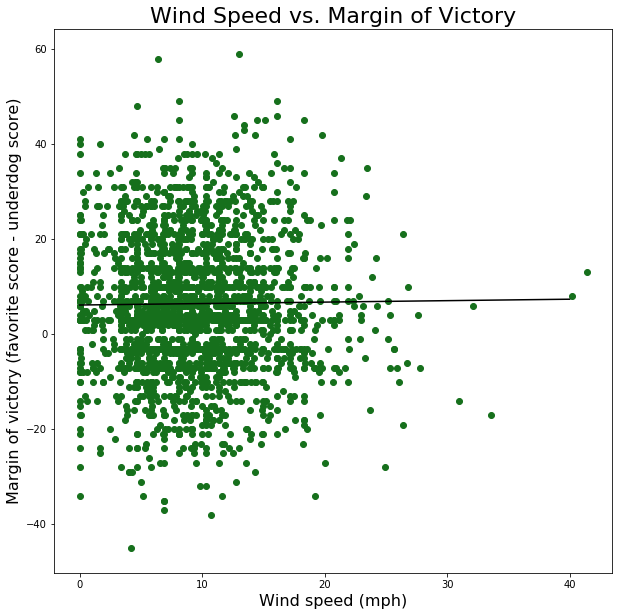

In [474]:
fig, ax = plt.subplots(figsize=(10,10));
fig = plt.scatter(outdoors_wind['wind_speed'], outdoors_wind['raw_margin_betting'], color = '#16701C')
x = np.arange(41)
fig = plt.plot(x, 0.0306*x + 6.1541, color = 'black')
plt.xlabel('Wind speed (mph)', fontsize = 16);
plt.ylabel('Margin of victory (favorite score - underdog score)', fontsize = 16);
plt.title('Wind Speed vs. Margin of Victory', fontsize = 22);

### Temperature vs Spread

In this last category, I will be comparing how teams do relative to the spread with different temperatures. Indoor games will be used as a reference, since they are all played at about room temperature. Since I want to know how favorites and underdogs perform against the spread (with the spread_margin metric), I will need to perform a similar data manipulation to what I did in the previous section. I will also use the dataframes with no pick'em games. Once again, positive values signify the favorite covering, and negative values signify the underdog covering.

#### Data Manipulation

In [466]:
def spread_betting(row):
    if row['spread_cover'] == row['favorite']:
        return abs(row['spread_margin']) ## Favorite covers, metric must be positive
    elif row['favorite'] == 'Home':
        return -row['spread_margin'] ## Away underdog wins, metric turns negative
    else:
        return row['spread_margin'] ## Home underdog wins, metric stays negative

## Apply to all dataframes
indoors_nopickem['spread_margin_betting'] = indoors.apply(spread_betting, axis = 1)
outdoors_nopickem['spread_margin_betting'] = outdoors.apply(spread_betting, axis = 1)

## Because there may be some NaNs in the temperature column, I will drop those from the analysis
outdoors_temp = outdoors_nopickem.dropna(subset = ['temp'])

#### Basic statistics of each population

In [464]:
indoors_nopickem['spread_margin_betting'].describe()

count    757.000000
mean      -0.212682
std       12.889244
min      -37.500000
25%       -8.000000
50%       -0.500000
75%        8.000000
max       41.000000
Name: spread_margin_betting, dtype: float64

In [467]:
outdoors_temp['spread_margin_betting'].describe()

count    2244.000000
mean        0.404857
std        13.757071
min       -52.000000
25%        -8.500000
50%         0.000000
75%         9.000000
max        50.000000
Name: spread_margin_betting, dtype: float64

#### t-test for population mean difference

Null: The two game conditions have the same population mean spread margin

Alternative: Betting favorites cover the spread by more in outdoor games compared to indoor games.

In [468]:
stats.ttest_ind(indoors_nopickem['raw_margin_betting'], outdoors_temp['raw_margin_betting'], equal_var=False)

Ttest_indResult(statistic=-0.6911046584043191, pvalue=0.48961520372509804)

Since p = 0.4896, we cannot reject the null hypothesis and conclude that there is a significant difference in spread margin for all indoor vs outdoor games.

#### Regression

In [469]:
stats.linregress(x= outdoors_temp['temp'], y=outdoors_temp['spread_margin_betting'])

LinregressResult(slope=-0.030293200251434754, intercept=2.24443088227388, rvalue=-0.036559677841659505, pvalue=0.08336656941313011, stderr=0.017487774967442766)

The regression here is relatively significant (only at the 0.10 level) and indicates that favorites perform slightly better vs the spread in outdoor when th temperature is lower.

#### Visualization

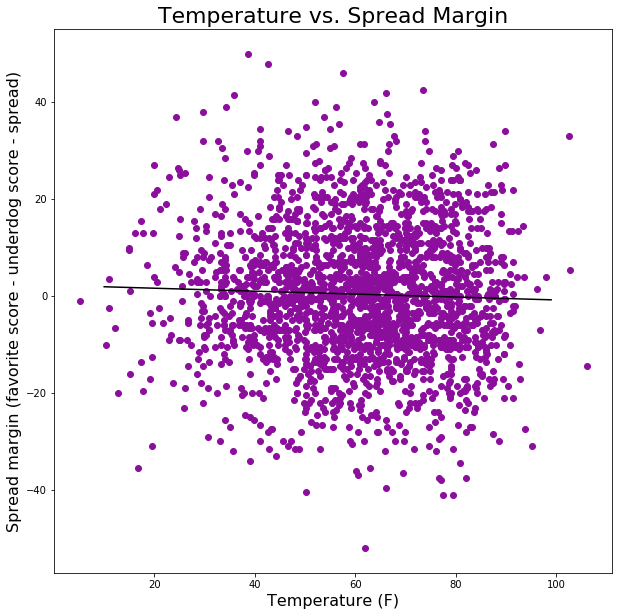

In [475]:
fig, ax = plt.subplots(figsize=(10,10));
fig = plt.scatter(outdoors_temp['temp'], outdoors_temp['spread_margin_betting'], color = '#8B0E9C')
x = np.arange(10,100,1)
fig = plt.plot(x, -0.0303*x + 2.2444, color = 'black')
plt.xlabel('Temperature (F)', fontsize = 16);
plt.ylabel('Spread margin (favorite score - underdog score - spread)', fontsize = 16);
plt.title('Temperature vs. Spread Margin', fontsize = 22);